In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Diffusity

┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278
┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

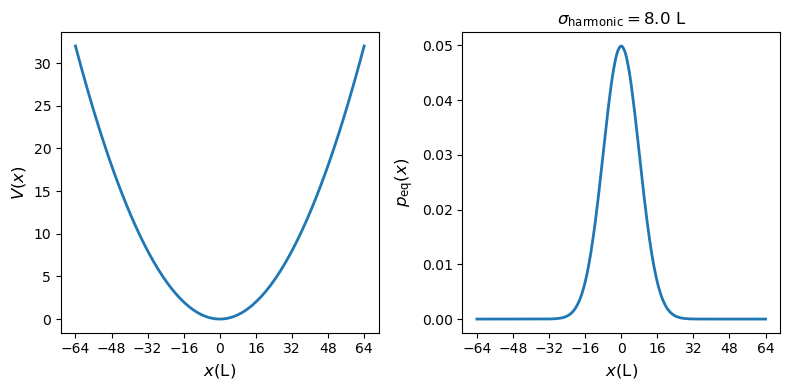

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

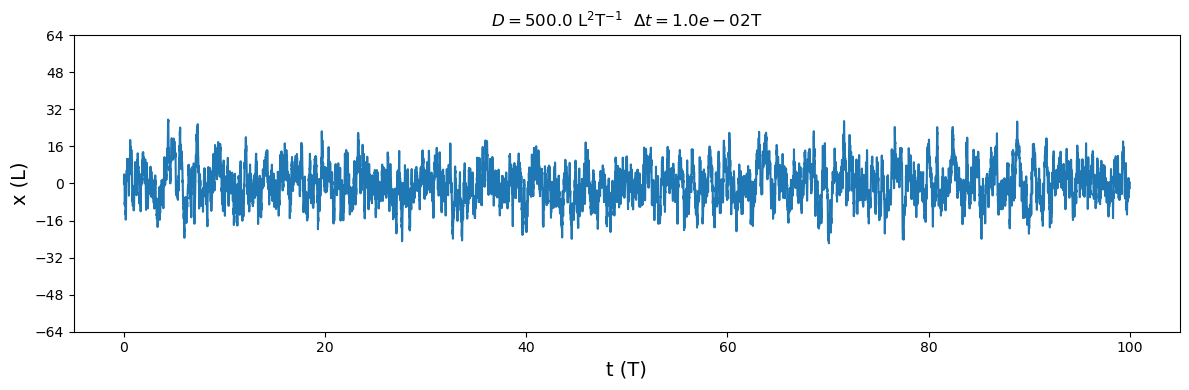

In [16]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get eigenvector and eigenvalues when $D=1$

In [6]:
D_unity = 1e0
eigenvalues_prime, eigenvect_mat_prime, rho_eq_by_fem_prime = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_unity, Nv)
weight_Qx_prime = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime);

### Part 5: Set Photon $\sigma$

In [7]:
σ_delta = 0.5
k_delta = get_k_by_sigma(σ_delta);

### Part 6: Scan D

In [51]:
D_array = [value for value=350.:10.:750.];

In [52]:
l_array = Diffusity.scan_l_by_vary_D(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, xref, e_norm, interpo_xs, 
    Np, k_delta, D_array, eigenvalues_prime, save_freq);

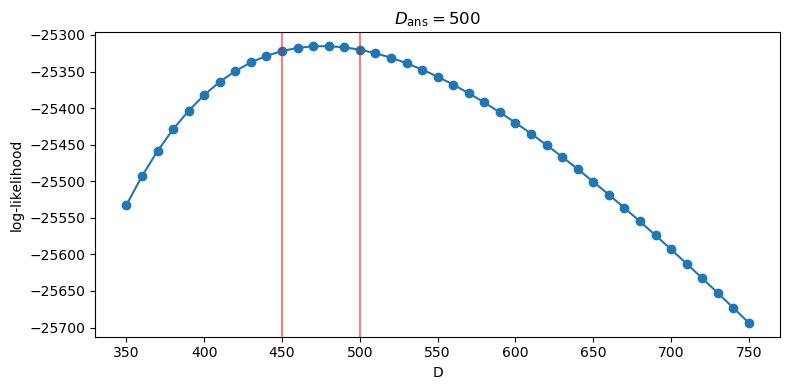

In [61]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(D_array, l_array, "-o")
ax.axvline(500, color="red", alpha=0.5)
ax.axvline(450, color="red", alpha=0.5)
ax.set_xlabel("D")
ax.set_ylabel("log-likelihood")
ax.set_title("\$D_{\\mathrm{ans}}=500\$")

plt.tight_layout()
plt.show()

### Part 7: $Q(\theta) = \sum_{t=1}^{N_p} \frac{\left<\hat{\alpha}^k_{t-1} | e^{-\textbf{H}\Delta t_{\tau}} \textbf{y}_{\tau} | \hat{\beta}_{t}\right> }{c_t}$

In [8]:
D_value = 500.
alpha_mat, beta_mat = Diffusity.calculate_Q(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, xref, e_norm, interpo_xs, 
    Np, k_delta, D_value, eigenvalues_prime, save_freq);

In [18]:
dot(alpha_mat[:,100], beta_mat[:,100])

1.000000000000549

In [ ]:
alpha_mat[1] * beta_mat[1]

### Part 7: $\left< \hat{\alpha}_{t} | x \right>$

In [34]:
time_idx_sele = 8585
alpha_hat_t = alpha_mat[:,time_idx_sele]
alpha_x = Diffusity.proj_vector_from_eigenspace_to_xspace(eigenvect_mat_prime, alpha_hat_t);

### Part 8: $\left< x | \hat{\beta}_{t} \right>$

In [35]:
beta_hat_t = beta_mat[:, time_idx_sele];
beta_x = Diffusity.proj_vector_from_eigenspace_to_xspace(eigenvect_mat_prime, beta_hat_t);

### Part 9: $\gamma(x_t)$

In [36]:
gamma_x = alpha_x .* beta_x;

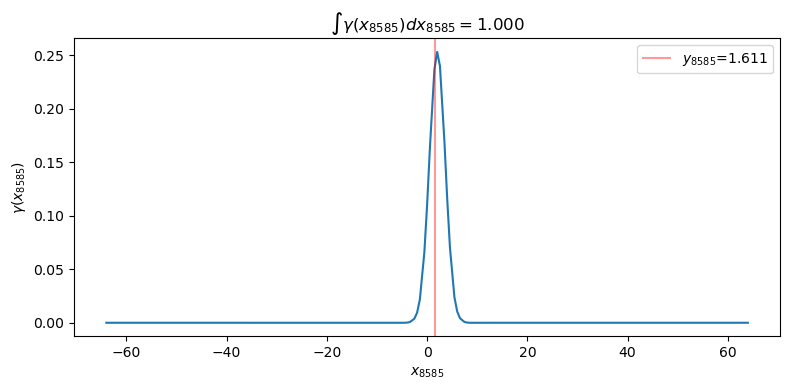

In [37]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(xref, gamma_x)
label= @sprintf "\$y_{%d}\$=%.3f" time_idx_sele y_record[time_idx_sele]
ax.axvline(y_record[time_idx_sele], color="red", alpha=0.4, label=label)
ax.set_xlabel(@sprintf "\$x_{%d}\$" time_idx_sele)
ax.set_ylabel(@sprintf "\$\\gamma(x_{%d})\$" time_idx_sele)
ax.legend()
title = @sprintf "\$\\int \\gamma(x_{%d}) dx_{%d}=%.3f\$" time_idx_sele time_idx_sele sum(w0 .* gamma_x)
ax.set_title(title)

plt.tight_layout()
plt.show()

In [16]:
dot(alpha_hat_t, beta_hat_t)

0.9999999999999999

In [14]:
beta_hat_t

72-element Array{Float64,1}:
  0.48235721770271256
 -2.1923216999129395e-11
  4.4531627974932645e-5
  5.474795399087066e-5
  0.27458135659075444
 -3.459743081400893e-11
  0.1914347605663899
 -1.3174901272670113e-10
 -0.14072539710225515
  1.1364909821209137e-9
  0.10600109703495748
 -6.241293800954054e-9
 -0.07535314710977334
  ⋮
  5.8527830784864724e-8
 -8.444361797648996e-14
  2.2337255980639953e-8
  2.9285012596351533e-14
  5.179066525172728e-9
  5.210479714605966e-15
  1.7599025506829551e-9
 -1.243762687224883e-16
  5.735087845475358e-10
  6.577114230957833e-16
 -1.6954820481956134e-10
 -2.7864924544259346e-16

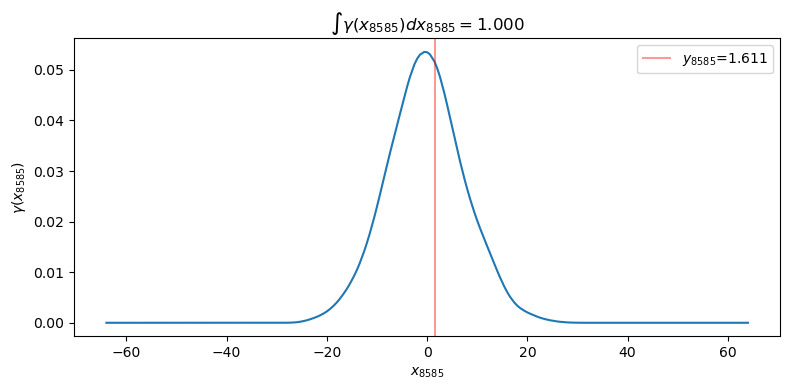

In [38]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(xref, peq_new_normalize)
label= @sprintf "\$y_{%d}\$=%.3f" time_idx_sele y_record[time_idx_sele]
ax.axvline(y_record[time_idx_sele], color="red", alpha=0.4, label=label)
ax.set_xlabel(@sprintf "\$x_{%d}\$" time_idx_sele)
ax.set_ylabel(@sprintf "\$\\gamma(x_{%d})\$" time_idx_sele)
ax.legend()
title = @sprintf "\$\\int \\gamma(x_{%d}) dx_{%d}=%.3f\$" time_idx_sele time_idx_sele sum(w0 .* gamma_x)
ax.set_title(title)

plt.tight_layout()
plt.show()